# Data preparation and creation of Milvus collections

In [17]:
import os
import time

import pandas as pd
import numpy as np
from dotenv import load_dotenv

from pymilvus import connections, utility, MilvusClient
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

from sentence_transformers import SentenceTransformer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["KMP_DUPLICATE_LIB_OK"] = "true"

In [3]:
load_dotenv()
MILVUS_HOST = os.environ['MILVUS_HOST']
MILVUS_TOKEN = os.environ['MILVUS_TOKEN']

HOST = MILVUS_HOST
TOKEN = MILVUS_TOKEN

MILVUS_USERS_COLLECTION = os.environ['MILVUS_USERS_COLLECTION']
MILVUS_SONGS_COLLECTION = os.environ['MILVUS_SONGS_COLLECTION']
MILVUS_ARTISTS_COLLECTION = os.environ['MILVUS_ARTISTS_COLLECTION']
MILVUS_USERS_ARTISTS_COLLECTION = os.environ['MILVUS_USERS_ARTISTS_COLLECTION']

DIMENSION = 384
BATCH_SIZE = 512

## Read and clean dataset

In [4]:
df = pd.read_csv("./dataset/Spotify Million Song Dataset_exported.csv")
df = df.dropna()

cleaned_df = df.loc[(df["text"].str.len() > 50)]
cleaned_df["text"] = cleaned_df["text"].str.replace("\n", " ")

In [5]:
connections.connect("default", uri=HOST, token=TOKEN)

In [6]:
def create_songs_collection():
    if utility.has_collection(MILVUS_SONGS_COLLECTION):
        utility.drop_collection(MILVUS_SONGS_COLLECTION)

    # object should be inserted in the format of (artist, song, embedding embedding)
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="song", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=MILVUS_SONGS_COLLECTION, schema=schema)

    collection.create_index(field_name="embedding", 
                            index_params={
                                "index_type": "IVF_FLAT",
                                "metric_type": "L2",
                                "params": {"nlist": 128},
                            })    
    collection.load()
    return collection

In [7]:
songs_collection = create_songs_collection()

## Create song embeddings

In [8]:
transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
def embed_insert(data, collection):
    try:
        texts = np.array(data[2])
        embeddings = transformer.encode(texts)

        insert_data = [
            {"artist": artist, "song": song, "embedding": embedding.tolist()}
            for artist, song, embedding in zip(data[0], data[1], embeddings)
        ]

        collection.insert(insert_data)
        return {f"{artist}-{song}": embedding.tolist() for artist, song, embedding in zip(data[0], data[1], embeddings)}
    except Exception as e:
        print(f"Error during embedding and insertion: {e}")
        return None

In [10]:
data_batch = [[], [], []]
song_vectors = {} 

for index, row in cleaned_df.iterrows():
    data_batch[0].append(row["artist"])
    data_batch[1].append(row["song"])
    data_batch[2].append(row["text"])

    if len(data_batch[0]) % BATCH_SIZE == 0:
        batch_vectors = embed_insert(data_batch, songs_collection)
        if batch_vectors is not None:
            song_vectors.update(batch_vectors)
        data_batch = [[], [], []]

if len(data_batch[0]) != 0:
    batch_vectors = embed_insert(data_batch, songs_collection)
    if batch_vectors is not None:
        song_vectors.update(batch_vectors)

try:
    songs_collection.flush()
    print("Flushed changes to the songs collection.")
except Exception as e:
    print(f"Error during flushing the songs collection: {e}")

Flushed changes to the songs collection.


## Calculate average vector for each artist

In [11]:
from collections import defaultdict

start_time = time.time()
artist_vectors = defaultdict(list)

for artist, song, embedding in zip(cleaned_df["artist"], cleaned_df["song"], song_vectors.values()):
    artist_vectors[artist].append(embedding)

artist_avg_vectors = {artist: np.mean(vectors, axis=0).tolist() for artist, vectors in artist_vectors.items()}

end_time = time.time()
execution_time = end_time - start_time
print(f"The average vector calculation elapsed: {execution_time} seconds")

The average vector calculation elapsed: 1.4175770282745361 seconds


In [12]:
def create_artist_collection():
    if utility.has_collection(MILVUS_ARTISTS_COLLECTION):
        utility.drop_collection(MILVUS_ARTISTS_COLLECTION)

    # object should be inserted in the format of (artist, embedding embedding)
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=MILVUS_ARTISTS_COLLECTION, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

In [13]:
collection_artists = create_artist_collection()

In [14]:
data_batch = [[], []]

for key, value in artist_avg_vectors.items():
    data_batch[0].append(key)
    data_batch[1].append(value)
    
    if len(data_batch[0]) % BATCH_SIZE == 0:
        collection_artists.insert(data_batch)
        data_batch = [[], []]

if len(data_batch[0]) != 0:
    collection_artists.insert(data_batch)

try:
    collection_artists.flush()
    print("Flushed changes to the artist collection")
except Exception as e:
    print(f"Error during flushing the artist collection: {e}")

Flushed changes to the artist collection


## Test the data

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

def search_and_evaluate(search_terms, collection, top_k=10):
    query_embedding = transformer.encode(search_terms)
    query_embedding = np.array(query_embedding)

    search_results = collection.search(
        data=query_embedding,
        anns_field="embedding",
        param={"metric_type": "L2", "params": {"nprobe": 20}},
        limit=top_k,
        output_fields=["artist", "song", "embedding"]
    )    
    
    results = []
    similarities = []
    for hit in search_results[0]:
        artist = hit.entity.get('artist')
        song = hit.entity.get('song')
        similarity = cosine_similarity(query_embedding, np.array([hit.entity.get('embedding')]))[0][0]
        similarities.append(similarity)
        results.append([artist, song, f"{similarity:.2f}"])

    print(tabulate(results, headers=["Artist", "Song", "Similarity"]))
    average_similarity = np.mean(similarities)
    print(f"Average similarity: {average_similarity:.2f}")
    return search_results, average_similarity

# Example of usage
search_terms = "I'm looking for a song about the epic battles, heroes and warriors of the True metal with hearts of steel"
results = search_and_evaluate([search_terms], songs_collection, top_k=20)


Artist          Song                     Similarity
--------------  ---------------------  ------------
Manowar         Army Of Immortals              0.51
Manowar         The Sons Of Odin               0.49
Manowar         Heart Of Steel                 0.48
Manowar         Call To Arms                   0.48
Leann Rimes     Love Is An Army                0.46
Manowar         Warriors Of The World          0.46
Michael Bolton  I'm Not Made Of Steel          0.46
W.A.S.P.        War Cry                        0.46
Chicago         Glory Of Love                  0.46
Ziggy Marley    Still The Storms               0.45
Manowar         Metal Daze                     0.45
The Script      Superheroes                    0.44
Manowar         The Lord Of Steel              0.44
Peter Cetera    Glory Of Love                  0.44
Manowar         Blood Of The Kings             0.44
Vince Gill      Live To Tell It All            0.44
Bon Jovi        Nobody's Hero                  0.43
Manowar     

## Visualization of the clusters of artists

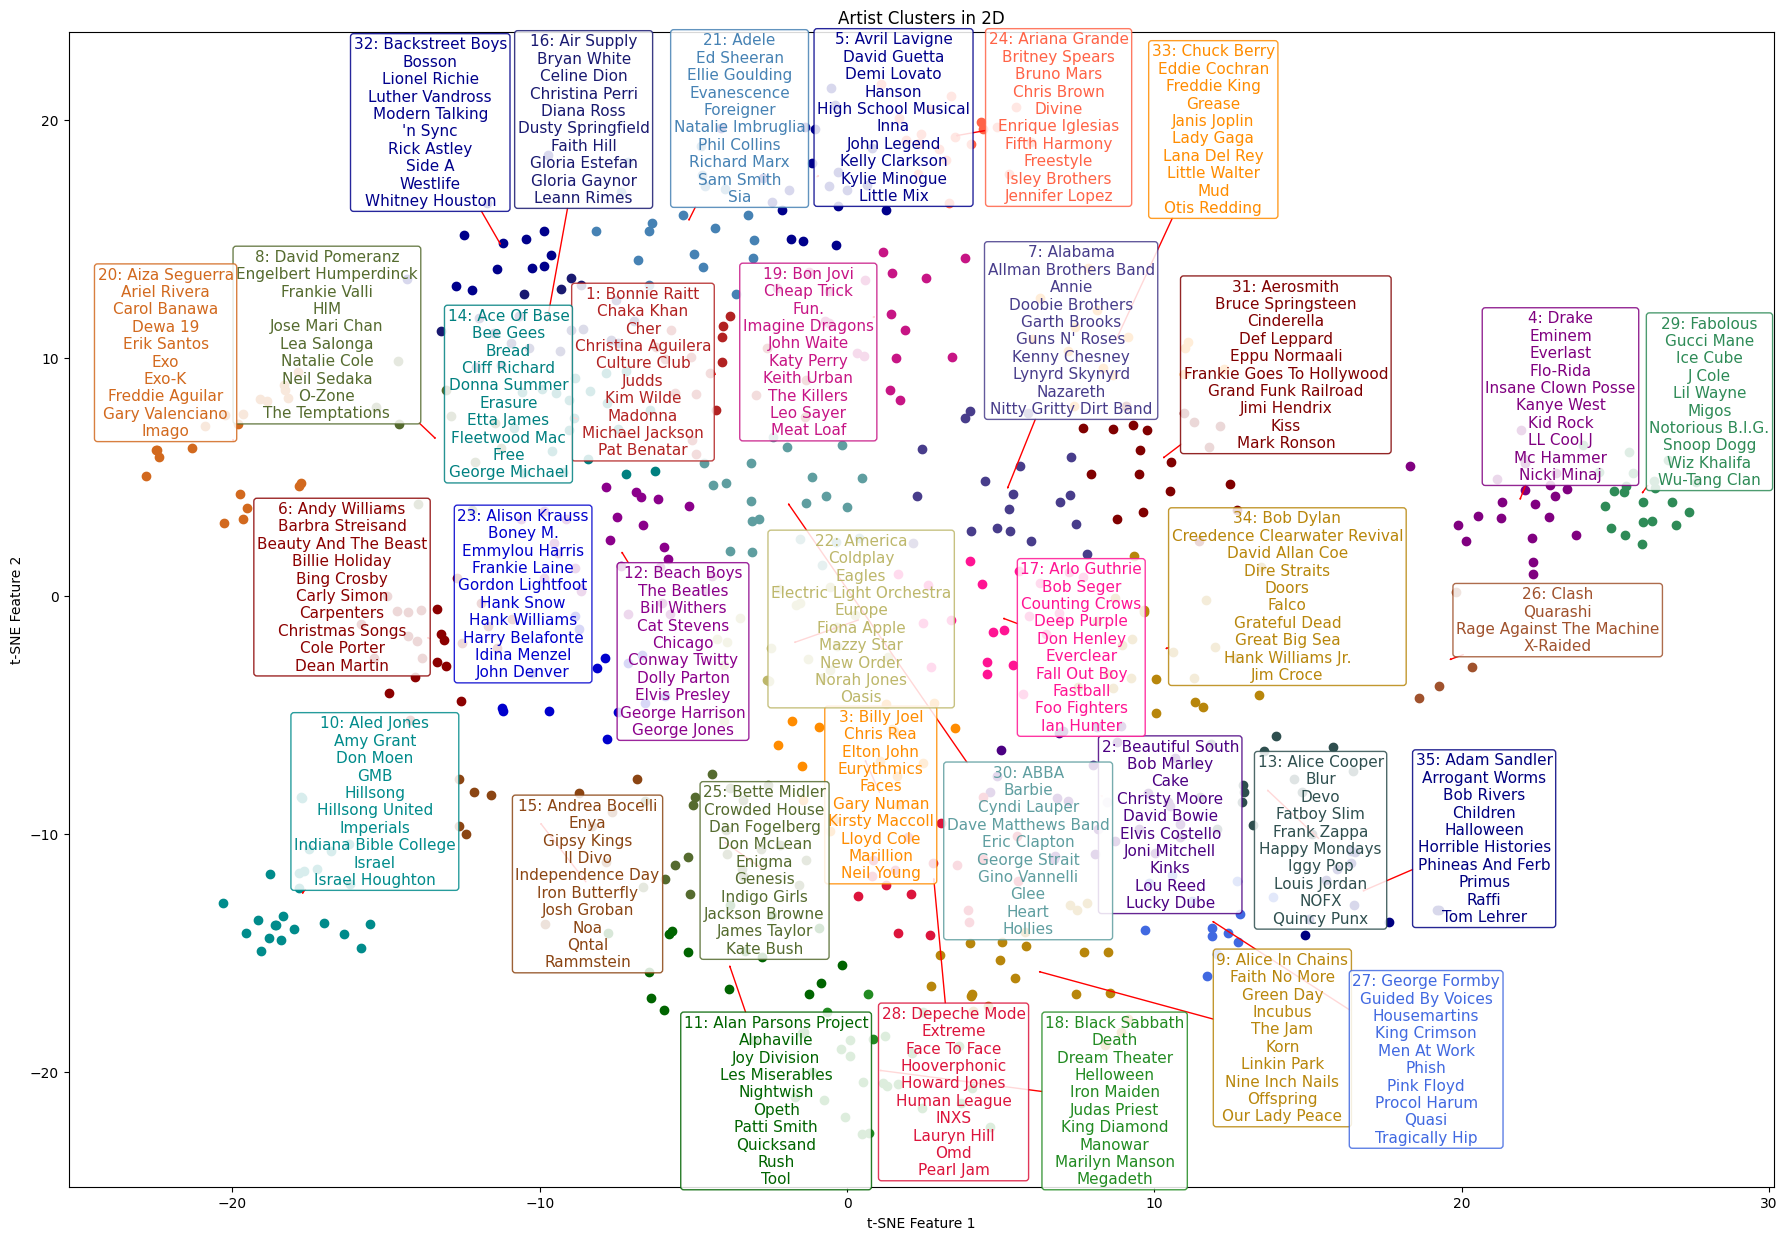

In [18]:
import numpy as np
from adjustText import adjust_text
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


artist_vectors_list = list(artist_avg_vectors.values())
artist_vectors_np = np.array(artist_vectors_list)

tsne = TSNE(n_components=2, random_state=1)
reduced_vectors = tsne.fit_transform(artist_vectors_np)

n_clusters = 35

kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(reduced_vectors)
labels = kmeans.labels_

plt.figure(figsize=(22, 15))

colors = [
    'firebrick', 'indigo', 'darkorange',
    'purple', 'darkblue', 'darkred', 'darkslateblue', 'darkolivegreen',
    'darkgoldenrod', 'darkcyan', 'darkgreen', 'darkmagenta', 'darkslategray', 'teal',
    'saddlebrown', 'midnightblue', 'deeppink', 'forestgreen', 'mediumvioletred',
    'chocolate', 'steelblue', 'darkkhaki', 'mediumblue', 'tomato',
    'darkolivegreen', 'sienna', 'royalblue', 'crimson', 'seagreen',
    'cadetblue', 'maroon', 'darkblue', 'darkorange', 'darkgoldenrod', 'navy'
]

assert len(colors) >= n_clusters, "There are not enough colors for all clusters"

texts = []

for i in range(n_clusters):
    cluster_color = colors[i]
    
    cluster_indices = [index for index, label in enumerate(labels) if label == i]
    cluster_points = reduced_vectors[cluster_indices]
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}', color=colors[i])

    cluster_center = np.mean(cluster_points, axis=0)

    artists_in_cluster = [list(artist_avg_vectors.keys())[index] for index in cluster_indices]
    artists_text = '\n'.join(artists_in_cluster[:10])

    text = plt.text(
        cluster_center[0], 
        cluster_center[1], 
        f'{i + 1}: {artists_text}',
        ha='center', 
        fontsize=11,
        color=colors[i],
        bbox=dict(facecolor='white', alpha=0.85, edgecolor=colors[i], boxstyle='round,pad=0.2')
    )
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Artist Clusters in 2D')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

## Get two random songs from each Cluster

In [19]:
from collections import defaultdict
import random

clusters = defaultdict(list)
for artist, label in zip(artist_avg_vectors.keys(), labels):
    clusters[label].append(artist)

sond_ids = []
for cluster, artists in clusters.items():
    artists_songs = defaultdict(list)
    
    selected_artists = random.sample(artists, min(2, len(artists)))

    print(f'Cluster {cluster + 1}: {selected_artists}')
    entities = songs_collection.query(
        expr=f'artist in {selected_artists}',
        output_fields=["id", "artist", "song"])

    if entities:
        for entity in entities:
            artists_songs[entity['artist']].append(entity['id'])

        for selected_artist in artists_songs:
            sond_ids.append(random.choice(artists_songs[selected_artist]))

print(sond_ids)

Cluster 30: ['Jason Mraz', 'Kelly Family']
Cluster 14: ['Donna Summer', 'Journey']
Cluster 35: ['Primus', 'Tom Lehrer']
Cluster 21: ['Tiffany', 'Adele']
Cluster 31: ['Frankie Goes To Hollywood', 'Kiss']
Cluster 16: ['Christina Perri', 'Faith Hill']
Cluster 20: ['X Japan', 'Carol Banawa']
Cluster 7: ['Townes Van Zandt', 'Zac Brown Band']
Cluster 11: ['Alan Parsons Project', 'Zao']
Cluster 10: ['Hillsong', 'Zoegirl']
Cluster 13: ['Rem', 'Fatboy Slim']
Cluster 9: ['Xentrix', 'Queens Of The Stone Age']
Cluster 23: ['Tim Buckley', 'Idina Menzel']
Cluster 22: ['Fiona Apple', 'Mazzy Star']
Cluster 15: ['Independence Day', 'Andrea Bocelli']
Cluster 6: ['Nat King Cole', 'Christmas Songs']
Cluster 24: ['Britney Spears', 'Usher']
Cluster 17: ['Waylon Jennings', 'Deep Purple']
Cluster 5: ['Demi Lovato', 'P!nk']
Cluster 32: ['Xscape', 'Rick Astley']
Cluster 12: ['Conway Twitty', 'Elvis Presley']
Cluster 2: ['Elvis Costello', 'Nirvana']
Cluster 25: ['Next To Normal', 'Jackson Browne']
Cluster 3: ['G

In [ ]:
## Create user*_collections

In [ ]:
def create_user_collection():
    if utility.has_collection(MILVUS_USERS_COLLECTION):
        utility.drop_collection(MILVUS_USERS_COLLECTION)

    # object should be inserted in the format of (artist, embedding embedding)
    fields = [
        FieldSchema(name="user_id", dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=MILVUS_USERS_COLLECTION, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

collection_users = create_user_collection()

In [ ]:
def create_user_artist_collection():
    if utility.has_collection(MILVUS_USERS_ARTISTS_COLLECTION):
        utility.drop_collection(MILVUS_USERS_ARTISTS_COLLECTION)

    fields = [
        FieldSchema(name="user_id", dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=MILVUS_USERS_ARTISTS_COLLECTION, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

collection_users_artiss = create_user_artist_collection()